# Fine-Tuning: Swin Transformers For Multi-Label Image Classification

## 多标签图像分类

在本教程中，我们将探讨如何针对多标签图像分类对视觉Transformer模型进行微调。

在多标签分类中，我们数据集里的每张图像会有一个或多个类别标签，这与多类别分类不同，在多类别分类中每张图像只有一个标签。

在本教程中，我们将对一个Swin Transformer进行微调，具体来说是从[Hugging Face Timm](https://huggingface.co/docs/timm/index)库中获取的`swin_s3_base_224`模型作为我们的预训练模型。

对于数据集，我们选用[Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)数据集，该数据集包含了用于多标签分类和目标检测的标注信息。

在本教程中，我们还将使用[Hugging Face accelerate](https://huggingface.co/docs/accelerate/index)来驱动我们的训练循环，并且在计算指标时，我们会使用[Hugging Face evaluate](https://huggingface.co/docs/evaluate/index)。

由于我们使用了`accelerate`，它使我们能够编写在分布式配置下也能自动运行的训练循环，并且支持混合精度、完全分片数据并行（FSDP）、DeepSpeed等。不过在本教程中，我们会让操作保持相当简单。

## 导入相关的依赖库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from pathlib import Path
from PIL import Image

import datasets

from transformers.optimization import get_cosine_schedule_with_warmup

from timm import list_models, create_model

from accelerate import Accelerator, notebook_launcher

import evaluate

## 下载 Pascal VOC 数据集

关于 Pascal VOC 数据集的详细介绍可以通过：[PascalVOC Dataset](../datasets/pascal_voc.ipynb)

We'll download the [Pascal VOC 2007](https://huggingface.co/datasets/fuliucansheng/pascal_voc) dataset from the Hugging Face hub using [datasets](https://huggingface.co/docs/datasets/index) library.

In [2]:
dataset = datasets.load_dataset(
    "fuliucansheng/pascal_voc", "voc2007_main", trust_remote_code=True
)
print(dataset)
print(dataset["train"][42])

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2501
    })
    validation: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2510
    })
    test: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 4952
    })
})
{'id': 42, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7F84EA8B6710>, 'height': 375, 'width': 500, 'classes': [19], 'objects': {'bboxes': [[1.0, 95.0, 240.0, 336.0]], 'classes': [19], 'difficult': [0]}}


**The dataset contains the following features:**

- `id`: unique id of the sample
- `image`: a `PIL.Image` format image.
- `height`: height of the image
- `width`: width of the image
- `classes`: a list of integer labels associated with the image
- `objects`: a dictionary of object bounding-box annotations. 包括了：`bbox`，`classes`，`difficult`

For this tutorial, we'll only be needing the `image` and the `classes` feature from the dataset.

These are all the unique the unique labels that are available in the dataset, 20 of them in total. Each image might have more than 1 label associated to it.

Since in the dataset, the classes are given in integer format. We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. It will make it easy for us to understand the labels during visualization. 

In [3]:
class_names = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Diningtable",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tv/monitor",
]

In [4]:
label2id = {c: idx for idx, c in enumerate(class_names)}
id2label = {idx: c for idx, c in enumerate(class_names)}

## 数据可视化

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method. 

As you'll notice, some of the images have more than 1 label.

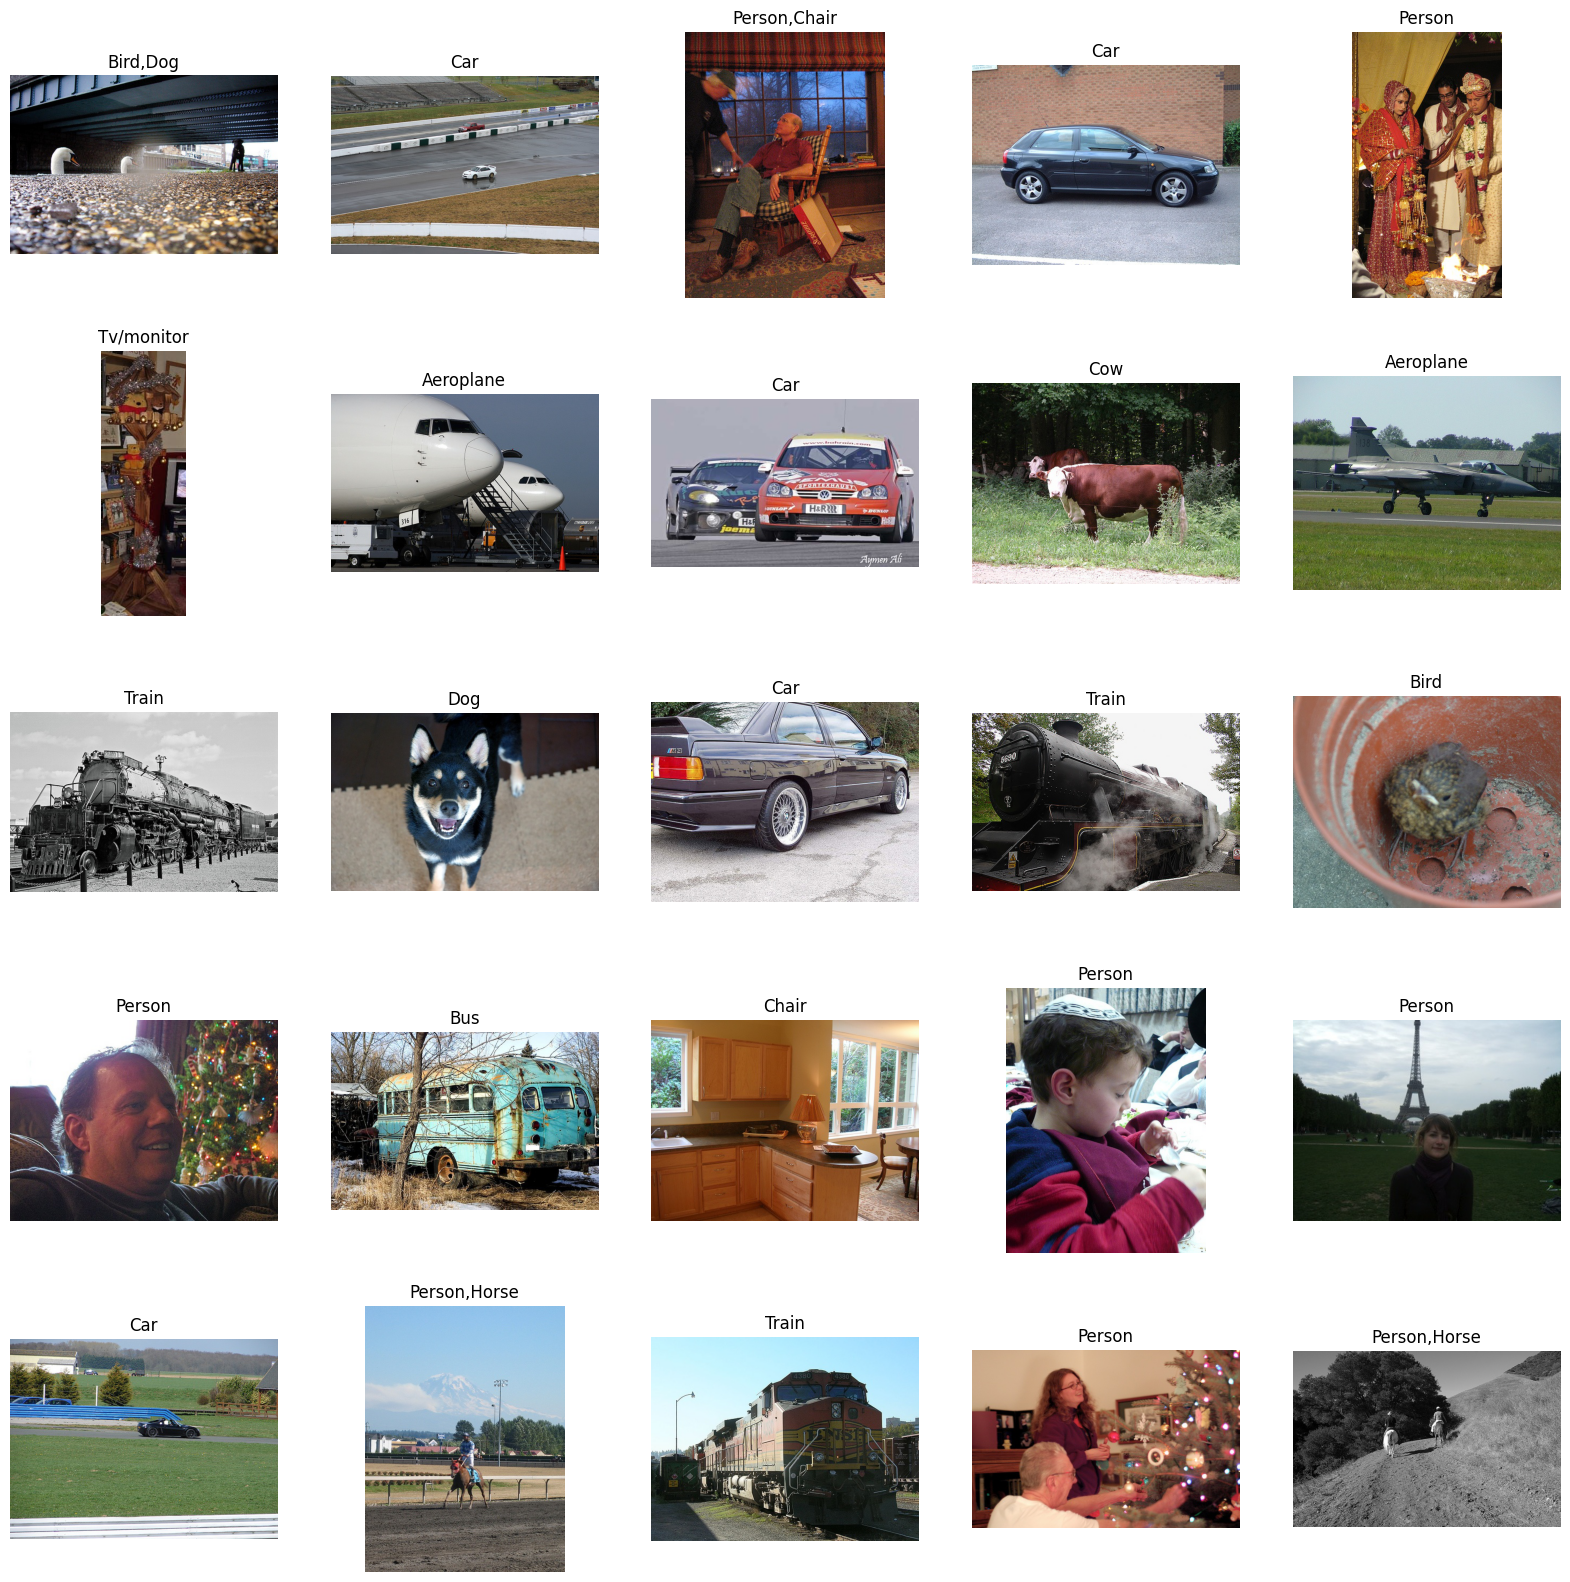

In [5]:
def show_samples(ds, rows, cols):
    samples = ds.shuffle().select(np.arange(rows * cols))  # selecting random images
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    # plotting
    for i in range(rows * cols):
        img = samples[i]["image"]
        labels = samples[i]["classes"]
        # getting string labels and combining them with a comma
        labels = ",".join([id2label[lb] for lb in labels])
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(labels)
        plt.axis("off")


show_samples(dataset["train"], rows=5, cols=5)

## 数据预处理

当涉及到图像数据集时，预处理包含多个步骤。我们将详细讨论这些步骤。为了对训练期间的样本批次应用这些图像和标签的转换操作，我们将定义 `train_transforms` 和 `valid_transforms` 函数，用于对样本进行预处理。

### 图像转换

这些转换包括将所有图像调整为相同的尺寸、标准化像素值以及将其缩放到统一的范围。我们还可以为图像添加增强操作，例如随机翻转、旋转、透视变换等。

为了实现这些转换和增强操作，我们将使用 [torchvision](https://pytorch.org/vision/stable/index.html) 提供的一些数据增强变换。

注意：随机增强（如翻转、旋转等）仅应用于训练数据集。因此，我们将创建两个不同的转换函数，分别为 `train_tfms`（用于训练）和 `valid_tfms`（用于验证和测试）。

具体的转换操作如下：

- **Resize（调整大小）**：模型名称 `swin_s3_base_224` 表明图像输入尺寸应为 224x224，因此我们会据此调整大小。
- **RandomHorizontalFlip（随机水平翻转）**：随机地水平翻转样本。
- **RandomRotation（随机旋转）**：在范围内旋转图像，这里为 (-30, +30) 度。
- **CenterCrop（中心裁剪）**：从图像中心裁剪。
- **ToTensor（转为张量）**：将 PIL 图像转换为 PyTorch 的张量（通道优先）并缩放到 [0,1] 范围。
- **Normalize（标准化）**：使用提供的均值和标准差对张量进行标准化。对于 Vision Transformers，通常的均值和标准差为 (0.5, 0.5, 0.5)，因此我们将使用该值。

### 标签转换

由于每个样本可能有多个标签，我们将使用 `one-hot encoding`（独热编码）将标签列表转换为一个由 0 和 1 组成的向量。该向量的长度等于标签的总数，在对应标签索引的位置，值为 1，其余位置为 0。

示例：

```
标签: [3,5], 总标签数 = 10
独热编码后的标签: [0 0 0 1 0 1 0 0 0 0]，在索引 3 和 5 的位置值为 1
```

在 PyTorch 中，我们将使用 `torch.nn.functional.one_hot` 来实现，该方法的工作方式如下：

当我们将一个样本或批次传递给 `train_transforms` 或 `valid_transforms` 函数时，`classes` 的形式为 `[[3,5]]`，即一个样本标签列表的列表。首先，我们将此列表转换为张量，然后进行独热编码。

当我们应用这种独热编码时，实际上是将这个问题转换为每个标签的二元分类问题。

In [6]:
sample_batch = [[2, 14]]  # 包含 1 个样本的批次
labels = torch.tensor(sample_batch)
labels = nn.functional.one_hot(labels, num_classes=20)  # 提供总类别数
print(labels.tolist())
labels = labels.sum(dim=1)
print(labels.tolist())

[[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]]
[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]


In [7]:
img_size = (224, 224)

train_tfms = T.Compose(
    [
        T.Resize(img_size),
        T.RandomHorizontalFlip(),
        T.RandomRotation(30),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

valid_tfms = T.Compose(
    [
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)


def train_transforms(batch):
    # Convert all images to RGB format
    if isinstance(batch["image"], list):
        # Batch processing
        batch["image"] = [x.convert("RGB") for x in batch["image"]]
        inputs = [train_tfms(x) for x in batch["image"]]
        batch["pixel_values"] = torch.stack(inputs)  # Stack tensor outputs
    else:
        # Single sample processing
        batch["image"] = batch["image"].convert("RGB")
        batch["pixel_values"] = train_tfms(batch["image"])

    # One-hot encode the multilabels
    all_labels = [torch.tensor(labels) for labels in batch["classes"]]

    # Create one-hot encoding for each image's classes
    one_hot_labels = [
        nn.functional.one_hot(label, num_classes=20).sum(dim=0) for label in all_labels
    ]

    # Stack them into a batch
    batch["labels"] = torch.stack(one_hot_labels)

    return batch


def valid_transforms(batch):
    # Convert all images to RGB format
    if isinstance(batch["image"], list):
        # Batch processing
        batch["image"] = [x.convert("RGB") for x in batch["image"]]
        inputs = [train_tfms(x) for x in batch["image"]]
        batch["pixel_values"] = torch.stack(inputs)  # Stack tensor outputs
    else:
        # Single sample processing
        batch["image"] = batch["image"].convert("RGB")
        batch["pixel_values"] = train_tfms(batch["image"])

    # One-hot encode the multilabels
    all_labels = [torch.tensor(labels) for labels in batch["classes"]]

    # Create one-hot encoding for each image's classes
    one_hot_labels = [
        nn.functional.one_hot(label, num_classes=20).sum(dim=0) for label in all_labels
    ]

    # Stack them into a batch
    batch["labels"] = torch.stack(one_hot_labels)

    return batch

We'll pair the preprocessing functions with our datasets using `with_transform` method.

In [8]:
train_dataset = dataset["train"].with_transform(train_transforms)
valid_dataset = dataset["validation"].with_transform(valid_transforms)
test_dataset = dataset["test"].with_transform(valid_transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2501, 2510, 4952)

### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for our one-hot encoded `labels`, the shape should be `(batch,num_labels)` 

In [9]:
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch]).float(),
    }

**A handy function to calculate the amount of trainable parameters in our model**

In [10]:
def param_count(model):
    params = [(p.numel(), p.requires_grad) for p in model.parameters()]
    trainable = sum([count for count, trainable in params if trainable])
    total = sum([count for count, _ in params])
    frac = (trainable / total) * 100
    return total, trainable, frac

## 使用 `timm` 加载预训练模型

我们可以使用`timm.create_model`从`timm`库中加载模型。

`timm.create_model`的参数：
- `name`：我们模型的名称。
- `num_classes`：我们数据集里的类别数量，这会用一个新的分类头替换预训练模型的分类器头，新的分类头的输出特征将等于类别数量。
- `pretrained`：设为`True`时，可获取我们模型的预训练权重。

要列出各种可用的模型，我们可以使用`timm.list_models`。我们可以传入一个字符串模式，比如`*swin*`或`*vit*`，它将匹配所有符合该模式的可用模型名称。你还可以传入`pretrained=True`，这样就只会列出带有可用预训练权重的模型。例如：`timm.list_models("*swin*", pretrained=True)`

## 模型训练

### 训练循环中相关组件

- **DataLoaders**:
    - to iterate over our datasets in batches, we define a dataloader using `torch.utils.data.DataLoader`.
    - we provide the per-device batch size to the dataloader
    - to enable/disable shuffling. True for training but False for validation and testing.
    - num_workers: defines the number of subprocesses which will be used to create our batches, a rule of thumb is to keep it equal to number of CPU cores.
    - collate_fn: we'll pass in the collate function we created earlier.
    
- **Loss Function**:
    - Since after one-hot encoding our labels, our task is equivalent to applying binary classification on each label, we'll be using `nn.BCEWithLogitsLoss()` which will take our predictions and targets of the shape `(batch, num_labels)`
    - `BCEWithLogitsLoss` 会先对输入进去的 logits 做 Sigmoid，将每个类别上的预测值转换为`(0,1)`之间，代表属于对应类别的概率。
    
- **Model**:
    - The model loaded from the `timm` library. 
    
- **Optimizer, Scheduler**:
    - Optimizer updates the weights of our model
    - Scheduler handles the change in the learning rate of our model during training. We'll be using `get_cosine_schedule_with_warmup` from `transformers.optimization`. In this scheduler, the learning rate increases gradually till `num_warmup_steps` and decays for the remaining steps with cosine annealing.

- **Metrics**:
    - we'll calculate metrics using `evaluate` library. We will be using `roc_auc` metric for `multilabel` with `micro` averaging which will calculate the metrics globally. For more explanation and references about the metric, check this [evaluate space](https://huggingface.co/spaces/evaluate-metric/roc_auc).
    

### 使用 `Accelerate` 来进行加速

- Accelerate takes care of device placement of our data and model automatically. We define as `accelerator` instance with `Accelerator()` along with any further configuration kwargs.
- We pass our model, dataloaders, optimizer, scheduler via `accelerator.prepare` method.
- To calculate metrics, we need to gather our batches from all devices, hence we use `accelerator.gather_for_metrics` to do so.
- To print only on the main process, we will use `accelerator.print`.


Since we'll be running from our Jupyter notebook, we'll be using `notebook_launcher`, which will call our `train` function that contains all of our logic and `accelerator` instance.


For further information and details on how to use `accelerate`, checkout the [docs](https://huggingface.co/docs/accelerate/index) and this handy [HF space](https://huggingface.co/spaces/hf-accelerate/accelerate_examples).

In [11]:
def train(model_name, batch_size=16, epochs=1, lr=2e-4):
    """
    contains all of our training loops.
    1. define Accelerator instance
    2. define dataloaders, model, optimizer, loss function, scheduler
    3. write training, validation and testing loop.
    """

    accelerator = Accelerator()  # create instance

    # define dataloaders

    train_dl = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,  # the batch_size will be per-device
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn,
    )

    valid_dl = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size * 2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )

    test_dl = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size * 2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
    )

    # timm model
    model = create_model(model_name, pretrained=True, num_classes=20).to(
        accelerator.device
    )  # device placement: accelerator.device

    total, trainable, frac = param_count(model)
    accelerator.print(f"{total = :,} | {trainable = :,} | {frac:.2f}%")

    # loss, optimizer, scheduler

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.02)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_dl)),
        num_training_steps=len(train_dl),
    )

    model, optimizer, scheduler, train_dl, valid_dl, test_dl = accelerator.prepare(
        model, optimizer, scheduler, train_dl, valid_dl, test_dl
    )

    # loops for number of epochs
    for epoch in range(1, epochs + 1):

        model.train()  # set model to train

        train_metric = evaluate.load("roc_auc", "multilabel")  # load metric

        running_loss = 0.0

        for batch in train_dl:

            logits = model(batch["pixel_values"])

            loss = loss_fn(logits, batch["labels"])
            accelerator.backward(loss)  # backpropagation
            optimizer.step()  # update weights
            scheduler.step()  # update LR
            optimizer.zero_grad()  # set grad values to zero

            running_loss += loss.item()  # keep track of loss

            # prepare for metrics
            logits, labels = accelerator.gather_for_metrics((logits, batch["labels"]))
            train_metric.add_batch(references=labels, prediction_scores=logits)

        # loss and metric over 1 epoch
        train_loss = running_loss / len(train_dl)
        train_roc_auc = train_metric.compute(average="micro")["roc_auc"]

        accelerator.print(f"\n{epoch = }")
        accelerator.print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")

        # validation loop

        model.eval()  # set model for evaluation

        running_loss = 0.0
        valid_metric = evaluate.load("roc_auc", "multilabel")

        for batch in valid_dl:

            with torch.no_grad():
                logits = model(batch["pixel_values"])

            loss = loss_fn(logits, batch["labels"])
            running_loss += loss.item()

            logits, labels = accelerator.gather_for_metrics((logits, batch["labels"]))
            valid_metric.add_batch(references=labels, prediction_scores=logits)

        valid_loss = running_loss / len(valid_dl)
        valid_roc_auc = valid_metric.compute(average="micro")["roc_auc"]

        accelerator.print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")

        # save model
        accelerator.save_model(model, f"logs/{model_name}-pascal")

    # testing loop after all epochs are over

    test_metric = evaluate.load("roc_auc", "multilabel")

    for batch in test_dl:

        with torch.no_grad():
            logits = model(batch["pixel_values"])

        logits, labels = accelerator.gather_for_metrics((logits, batch["labels"]))
        test_metric.add_batch(references=labels, prediction_scores=logits)

    test_roc_auc = test_metric.compute(average="micro")["roc_auc"]

    accelerator.print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")

### 提交训练 🚀️🚀️🚀️

with `notebook_launcher`, we start the training procedure by calling our `train` function with the args `(model_name, batch_size, epochs, lr)` as we defined above, and `num_processes` equal to the amount of GPUs.

In [12]:
model_name = "swin_s3_base_224"
notebook_launcher(train, (model_name, 8, 5, 5e-5), num_processes=1)

Launching training on one GPU.


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


total = 70,372,142 | trainable = 70,372,142 | 100.00%

epoch = 1
train_loss = 0.238 | train_roc_auc = 0.772
valid_loss = 0.157 | valid_roc_auc = 0.921
[2024-11-24 11:19:41,681] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlopen'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlclose'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlerror'
/data/envs/cuda-12.1/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status



epoch = 2
train_loss = 0.125 | train_roc_auc = 0.953
valid_loss = 0.081 | valid_roc_auc = 0.980

epoch = 3
train_loss = 0.058 | train_roc_auc = 0.990
valid_loss = 0.056 | valid_roc_auc = 0.990

epoch = 4
train_loss = 0.048 | train_roc_auc = 0.993
valid_loss = 0.060 | valid_roc_auc = 0.987

epoch = 5
train_loss = 0.031 | train_roc_auc = 0.998
valid_loss = 0.052 | valid_roc_auc = 0.990


TEST AUROC: 0.990


## 模型推理

When we save a model with `accelerate.save_model`, it saves it in [safetensors format](https://huggingface.co/docs/safetensors/index).

In [13]:
# intialize the model

model = create_model(model_name, num_classes=20)

In [14]:
from safetensors.torch import load_model

In [15]:
load_model(model, f"logs/{model_name}-pascal/model.safetensors")

(set(), [])

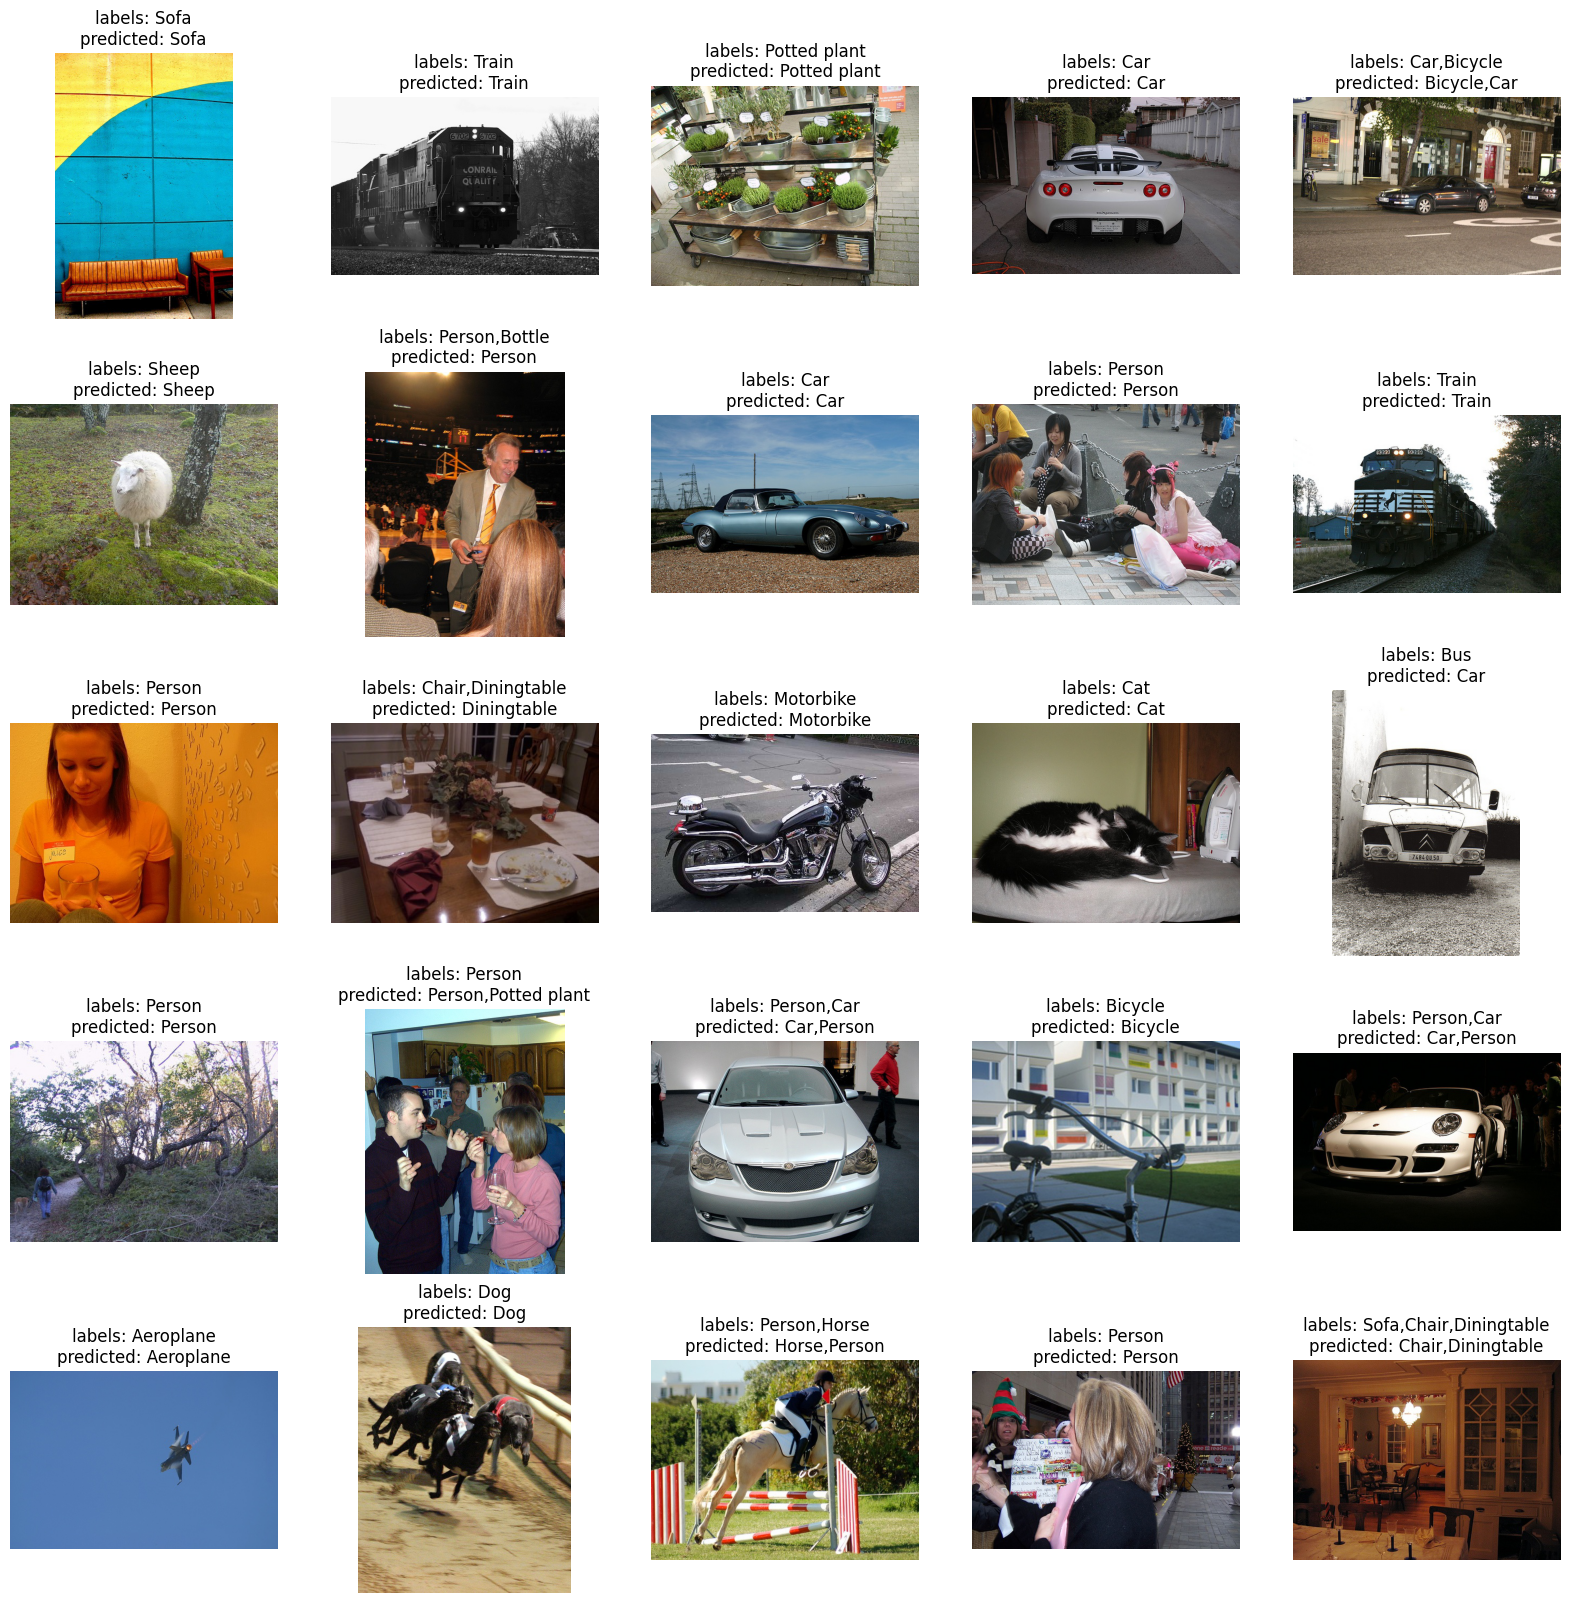

In [16]:
def show_predictions(rows=2, cols=4):
    model.eval()
    samples = test_dataset.shuffle().select(np.arange(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    for i in range(rows * cols):

        img = samples[i]["image"]
        inputs = samples[i]["pixel_values"].unsqueeze(0)
        labels = samples[i]["classes"]
        labels = ",".join([id2label[lb] for lb in labels])

        with torch.no_grad():
            logits = model(inputs)

        # apply sigmoid activation to convert logits to probabilities
        # getting labels with confidence threshold of 0.5
        predictions = logits.sigmoid() > 0.5

        # converting one-hot encoded predictions back to list of labels
        predictions = (
            predictions.float().numpy().flatten()
        )  # convert boolean predictions to float
        pred_labels = np.where(predictions == 1)[
            0
        ]  # find indices where prediction is 1
        pred_labels = ",".join(
            [id2label[label] for label in pred_labels]
        )  # converting integer labels to string

        label = f"labels: {labels}\npredicted: {pred_labels}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")


show_predictions(rows=5, cols=5)